[Ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) is a classification method for categories on an ordinal scale -- e.g. [1, 2, 3, 4, 5] or [G, PG, PG-13, R].  This notebook implements ordinal regression using the method of [Frank and Hal 2001](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf), which transforms a k-multiclass classifier into k-1 binary classifiers (each of which predicts whether a data point is above a threshold in the ordinal scale -- e.g., whether a movie is "higher" than PG).  This method can be used with any binary classification method that outputs probabilities; here L2-regularizaed binary logistic regression is used.

This notebook trains a model (on `train.txt`), optimizes L2 regularization strength on `dev.txt`, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

In [ ]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Annotation Project Girlies/'
# adjudicated_file_path = file_path + 'adjudicated.txt'
# data = pd.read_csv(adjudicated_file_path, delimiter='\t')

# train, temp = train_test_split(data, test_size=0.4, random_state=42)
# dev, test = train_test_split(temp, test_size=0.5, random_state=42)

# os.makedirs('/content/drive/My Drive/Annotation Project Girlies/splits', exist_ok=True)
# train.to_csv(file_path + 'splits/train.txt', index=False, sep='\t')
# dev.to_csv(file_path + 'splits/dev.txt', index=False, sep='\t')
# test.to_csv(file_path + 'splits/test.txt', index=False, sep='\t')


In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])

    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)

            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)

    return X, Y, orig_Y



In [ ]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY

        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):

        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape


        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model

    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]

        preds=np.array(preds)

        for data_point in range(len(preds[0])):


            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot

    # Returns predicrtions of above method
    def predict(self):
      cor = tot = 0
      counts = Counter()
      preds = [None] * (len(self.ordinal_values) - 1)
      all_predictions = []
      for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
          preds[idx] = self.log_regs[idx].predict_proba(self.testX)[:, 1]

      preds = np.array(preds)

      for data_point in range(len(preds[0])):
          ordinal_preds = np.zeros(len(self.ordinal_values))
          for ordinal in range(len(self.ordinal_values) - 1):
              if ordinal == 0:
                  ordinal_preds[ordinal] = 1 - preds[ordinal][data_point]
              else:
                  ordinal_preds[ordinal] = preds[ordinal - 1][data_point] - preds[ordinal][data_point]
          ordinal_preds[len(self.ordinal_values) - 1] = preds[len(preds) - 1][data_point]
          prediction = np.argmax(ordinal_preds)
          all_predictions.append(self.ordinal_values[prediction])
          counts[prediction] += 1
          if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
              cor += 1
          tot += 1

      return all_predictions

    # Gets feature importances
    def get_feature_importance(self):
        feature_importances = {}
        for idx, model in enumerate(self.log_regs):
            if model is not None:
                for feature, fid in self.feature_vocab.items():
                    if feature in feature_importances:
                        feature_importances[feature].append(model.coef_[0][fid])
                    else:
                        feature_importances[feature] = [model.coef_[0][fid]]
        return feature_importances

    def aggregate_feature_importance(self):
      raw_importances = self.get_feature_importance()
      aggregated_importances = {}
      for feature, importances in raw_importances.items():
          normalized_importance = [abs(imp) for imp in importances]
          aggregated_importances[feature] = sum(normalized_importance) / len(normalized_importance)
      return aggregated_importances

    # Creates visual for aggregated feature imporantances
    def visualize_feature_importance(self):
      importances = self.aggregate_feature_importance()
      sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)
      # for i in range(10):
      #   print(sorted_features[i])
      features, values = zip(*sorted_features)
      plt.barh(features, values, color='skyblue')
      plt.xlabel('Average Normalized Importance')
      plt.title('Feature Importances')
      plt.gca().invert_yaxis()
      plt.show()



In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats

In [ ]:
def combined_featurize(text):
    feats = {}

    # Feature extraction from punctuation counts
    for char in ['!', ',', '?']:
        if char in text:
            feats[char] = text.count(char)

    # Feature extraction from average word lengths
    words = nltk.word_tokenize(text)
    avg_word_length = sum(len(word) for word in words) / len(words)
    feats['average_word_length'] = avg_word_length

    # Feature extraction from non-emotive word counts
    non_emotive_words = ["the", "a", "an", "of", "than", "i", 'it']
    review_lower = text.lower()
    count = 0
    for word in review_lower:
      if word in non_emotive_words:
          count += 1
    feats['non_emotive'] = count

    # Check for excessive/repeated use of capital letters in a row for each review
    words = re.findall(r'\b\w+\b', text)
    for word in words:
        consecutive_capitals = max(re.findall(r'[A-Z]{2,}', word), default='')
        if consecutive_capitals:
            feats['caps_lock_usage'] = len(consecutive_capitals)

    return feats

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(trainingFile, devFile, testFile, ordinal_values):

    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

    simple_classifier = OrdinalClassifier(ordinal_values, combined_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))
    return simple_classifier

In [ ]:
trainingFile = file_path + "splits/train.txt"
devFile = file_path + "splits/dev.txt"
testFile = file_path + "splits/test.txt"

ordinal_values=["1", "2", "3"]

model = run(trainingFile, devFile, testFile, ordinal_values)

Test accuracy for best dev model: 0.683, 95% CIs: [0.592 0.774]



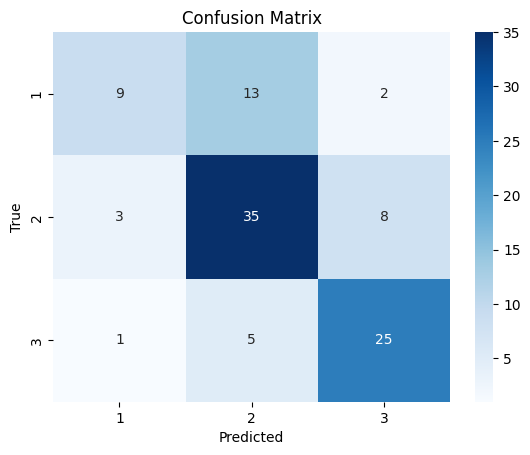

In [ ]:
trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

predictions = model.predict()
cm = confusion_matrix(model.orig_testY, predictions, labels=ordinal_values)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=ordinal_values, yticklabels=ordinal_values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

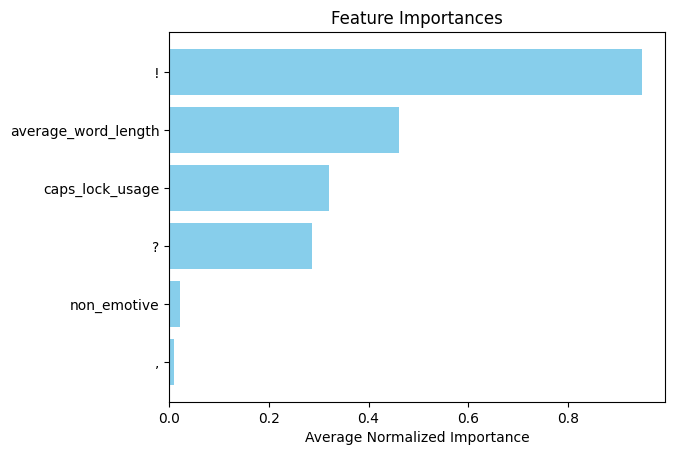

In [ ]:
model.visualize_feature_importance()

cp: target 'Girlies/OrdinalRegression.ipynb' is not a directory
[NbConvertApp] WARNING | pattern 'OrdinalRegression.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prom